In [38]:
import numpy as np
from scipy.sparse.csgraph import floyd_warshall

In [39]:
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
edges = [
    ('k', 'l', 3), ('k', 'e', 6), ('k', 'h', 3),
    ('h', 'l', 1), ('h', 'e', 3), ('e', 'a', 1),
    ('e', 'f', 4), ('a', 'd', 1), ('a', 'b', 4),
    ('a', 'c', 3), ('d', 'b', 4), ('d', 'f', 2),
    ('f', 'l', 3), ('f', 'g', 3), ('f', 'i', 4),
    ('f', 'b', 3), ('b', 'c', 5), ('c', 'g', 1),
    ('g', 'm', 1), ('g', 'j', 4), ('i', 'l', 1),
    ('i', 'j', 6), ('j', 'm', 2), ('j', 'l', 4),
    ('m', 'l', 5)
]

In [40]:
# 创建初始化为无穷大的矩阵，因为大多数节点间最初没有路径
n = len(nodes)
adj_matrix = np.full((n, n), np.inf)

# 节点到矩阵索引的映射
node_index = {node: idx for idx, node in enumerate(nodes)}

# 用边的权重填充矩阵
for src, dst, weight in edges:
    i, j = node_index[src], node_index[dst]
    adj_matrix[i][j] = weight
    adj_matrix[j][i] = weight  # 假设是无向图

# 对于无自环的情况将无穷大替换为0
np.fill_diagonal(adj_matrix, 0)

In [41]:
print(adj_matrix)

[[ 0.  4.  3.  1.  1. inf inf inf inf inf inf inf inf]
 [ 4.  0.  5.  4. inf  3. inf inf inf inf inf inf inf]
 [ 3.  5.  0. inf inf inf  1. inf inf inf inf inf inf]
 [ 1.  4. inf  0. inf  2. inf inf inf inf inf inf inf]
 [ 1. inf inf inf  0.  4. inf  3. inf inf  6. inf inf]
 [inf  3. inf  2.  4.  0.  3. inf  4. inf inf  3. inf]
 [inf inf  1. inf inf  3.  0. inf inf  4. inf inf  1.]
 [inf inf inf inf  3. inf inf  0. inf inf  3.  1. inf]
 [inf inf inf inf inf  4. inf inf  0.  6. inf  1. inf]
 [inf inf inf inf inf inf  4. inf  6.  0. inf  4.  2.]
 [inf inf inf inf  6. inf inf  3. inf inf  0.  3. inf]
 [inf inf inf inf inf  3. inf  1.  1.  4.  3.  0.  5.]
 [inf inf inf inf inf inf  1. inf inf  2. inf  5.  0.]]


In [42]:
import networkx as nx
import itertools

# 创建无向图
G = nx.Graph()

# 添加节点
G.add_nodes_from(nodes)

# 添加边
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# 找出所有奇度数顶点
odd_degree_nodes = [node for node, degree in G.degree() if degree % 2 == 1]

# 为奇度数顶点之间添加边，使之变成欧拉图
def add_edges_to_make_eulerian(G, odd_degree_nodes):
    # 找出所有奇度数顶点对的最短路径
    pairs = list(itertools.combinations(odd_degree_nodes, 2))
    shortest_paths = {}
    for u, v in pairs:
        shortest_paths[(u, v)] = nx.shortest_path_length(G, u, v, weight='weight')

    # 贪心算法：选择最短路径的顶点对来添加边
    added_edges = []
    while odd_degree_nodes:
        u, v = min(shortest_paths.keys(), key=lambda pair: shortest_paths[pair])
        G.add_edge(u, v, weight=shortest_paths[(u, v)])
        added_edges.append((u, v, shortest_paths[(u, v)]))
        odd_degree_nodes.remove(u)
        odd_degree_nodes.remove(v)
        shortest_paths = {pair: dist for pair, dist in shortest_paths.items() if u not in pair and v not in pair}

    return added_edges

added_edges = add_edges_to_make_eulerian(G, odd_degree_nodes)
print("添加的边：", added_edges)

# 检查是否现在是欧拉图
print("是否为欧拉图:", nx.is_eulerian(G))


添加的边： [('c', 'm', 2), ('h', 'i', 2), ('d', 'k', 8)]
是否为欧拉图: True


In [43]:
# 找到欧拉回路
euler_circuit = list(nx.eulerian_circuit(G))
euler_path = [u for u, v in euler_circuit] + [euler_circuit[-1][1]]
total_distance = sum(G[u][v]['weight'] for u, v in euler_circuit)

print("欧拉巡回的路径：", euler_path)
print("欧拉巡回的距离：", total_distance)


欧拉巡回的路径： ['a', 'c', 'm', 'l', 'j', 'm', 'g', 'j', 'i', 'l', 'h', 'i', 'f', 'l', 'k', 'h', 'e', 'f', 'g', 'c', 'b', 'f', 'd', 'b', 'a', 'd', 'k', 'e', 'a']
欧拉巡回的距离： 89


In [44]:
# 从指定顶点出发找到欧拉回路
def find_eulerian_path_from_start(G, start):
    if nx.is_eulerian(G):
        euler_circuit = list(nx.eulerian_circuit(G, source=start))
    else:
        odd_degree_nodes = [node for node, degree in G.degree() if degree % 2 == 1]
        euler_circuit = list(nx.eulerian_path(G, source=start, keys=False))

    euler_path = [u for u, v in euler_circuit] + [euler_circuit[-1][1]]
    total_distance = sum(G[u][v]['weight'] for u, v in euler_circuit)

    return euler_path, total_distance

start_node = 'g'
euler_path_from_start, total_distance_from_start = find_eulerian_path_from_start(G, start_node)

print(f"从顶点 {start_node} 出发的巡检的最短路径：", euler_path_from_start)
print(f"从顶点 {start_node} 出发的巡检距离：", total_distance_from_start)

从顶点 g 出发的巡检的最短路径： ['g', 'j', 'l', 'm', 'j', 'i', 'l', 'h', 'i', 'f', 'l', 'k', 'h', 'e', 'f', 'g', 'm', 'c', 'b', 'f', 'd', 'b', 'a', 'd', 'k', 'e', 'a', 'c', 'g']
从顶点 g 出发的巡检距离： 89


In [51]:
# 从指定顶点出发找到欧拉回路
def find_eulerian_path_between_nodes(G, start, end):
    # 找到欧拉路径
    euler_path = list(nx.eulerian_path(G, source=start))
    path = [u for u, v in euler_path] + [euler_path[-1][1]]
    total_distance = sum(G[u][v]['weight'] for u, v in euler_path)

    # 如果指定了终点，则调整路径
    if path[-1] != end:
        path = path + nx.shortest_path(G, path[-1], end)[1:]
        total_distance += nx.shortest_path_length(G, path[-2], end, weight='weight')

    return path, total_distance

# 指定起点和终点
start_node = 'a'
end_node = 'e'

# 找到欧拉路径并计算总距离
euler_path, total_distance = find_eulerian_path_between_nodes(G, start_node, end_node)

print(f"从顶点 {start_node} 出发到顶点 {end_node} 结束的巡检的最短路径：", euler_path)
print(f"从顶点 {start_node} 出发到顶点 {end_node} 结束的巡检距离：", total_distance)

从顶点 a 出发到顶点 e 结束的巡检的最短路径： ['a', 'e', 'k', 'd', 'a', 'b', 'd', 'f', 'b', 'c', 'g', 'f', 'e', 'h', 'k', 'l', 'f', 'i', 'h', 'l', 'i', 'j', 'g', 'm', 'j', 'l', 'm', 'c', 'a', 'e']
从顶点 a 出发到顶点 e 结束的巡检距离： 90


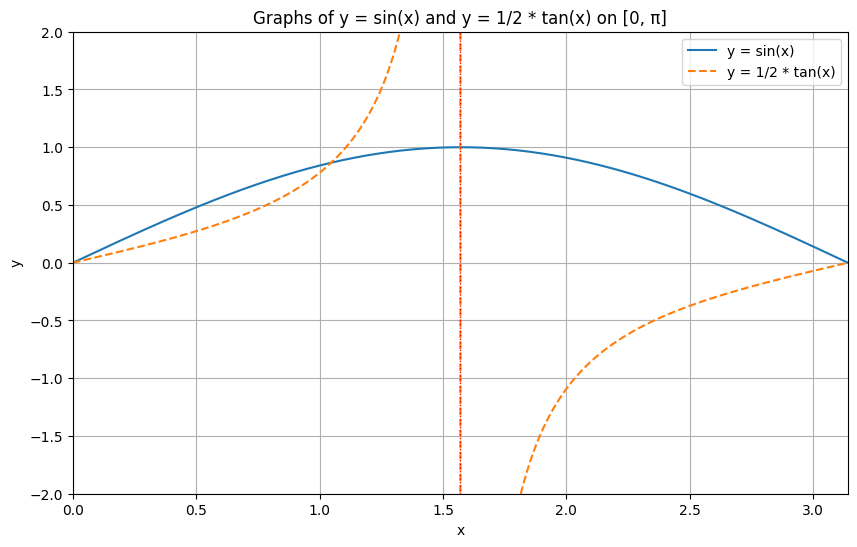

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义x的取值范围
x = np.linspace(0, np.pi, 400)
y1 = np.sin(x)

# 为了避免tan(x)在区间内的无定义点，设置一个较大的取值范围
x_tan = np.linspace(0, np.pi, 1000)
y2 = 0.5 * np.tan(x_tan)

# 绘制图像
plt.figure(figsize=(10, 6))

# 绘制y = sin(x)
plt.plot(x, y1, label='y = sin(x)')

# 绘制y = 1/2 * tan(x)
plt.plot(x_tan, y2, label='y = 1/2 * tan(x)', linestyle='--')

# 设置坐标轴范围
plt.xlim(0, np.pi)
plt.ylim(-2, 2)

# 标记不连续点（tan函数的无定义点）
discontinuities = np.arange(0, np.pi, np.pi/2)[1:]
for point in discontinuities:
    plt.axvline(x=point, color='r', linestyle=':', linewidth=1)

# 添加标题和图例
plt.title('Graphs of y = sin(x) and y = 1/2 * tan(x) on [0, π]')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# 显示图像
plt.show()
